<a href="https://colab.research.google.com/github/ksaiakhil96/Dogs-vs-Cats-Image-Processing/blob/master/CNNImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I create a convolutional neural network to classify images of cats and dogs. 

I used Kaggle API to directly load the train and test images and I created the notebook in Google Colab to make use of the GPU that they offered.

Initially, I started with a basic convolutional neural network, where I had 2 blocks of convolution and pooling layers, and then I had the dense neural network. I fitted this model to tha training data and it gave me an accuracy of around 82% on the validation dataset. The test data gave me a log loss of 0.89 .

So the basic CNN model wasn't good enough to classify images very well. I tried other variations of the basic CNN by increasing the neurons, and the number of layers and also using kernel reguarizers. Then I used a pretrained model - **resnet**. The core idea of ResNet is introducing a so-called “identity shortcut connection” that skips one or more layers. My intial block was the resnet and the next few layers were a dense network consisting of 3 dense layers. I used early stopping method along with kernel regularizer to prevent overfitting of the model to the training data. Relu was used as the activation function.

This model performed very well and gave me an accuracy of around 98% on the validation data and a loss of 0.0593. On the test data, I get a great performance as well. The **log loss score** on the test dataset after uploading on Kaggle is ***0.09***.

Below is the screen shot of my score after uploading on Kaggle!

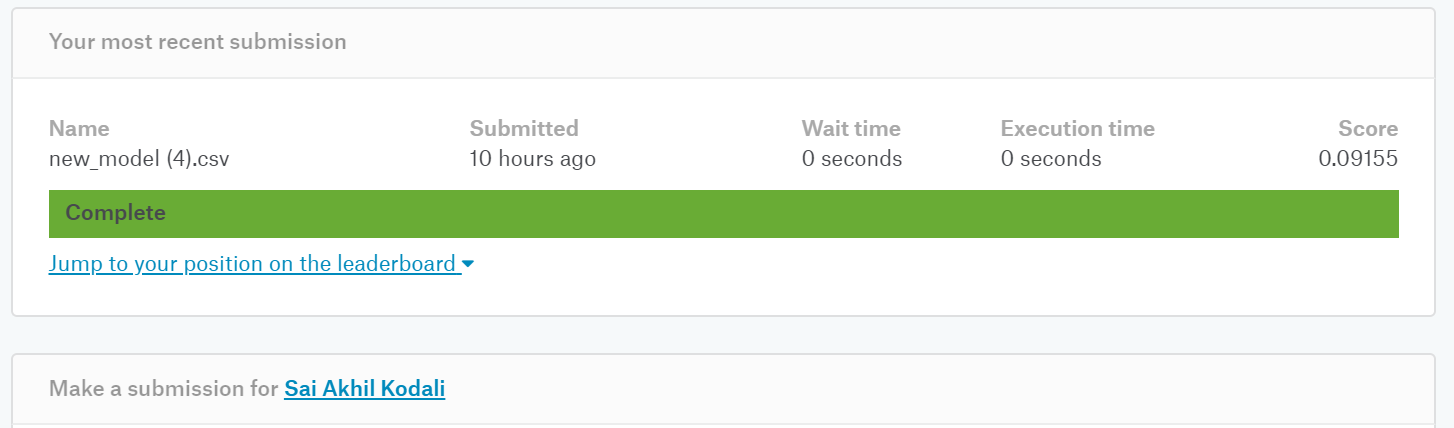

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ksaiakhil","key":"e2c7811f4aa30074a03068347aaa9a90"}'}

In [0]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# List available datasets.
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          3MB  2019-07-05 09:58:02           9948  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16          15377  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data                           4MB  2019-08-21 14:51:34           6391  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16          12898  
chirin/africa-economic-banking-and-systemic-crisis-data  Africa Economic, Banking and Sy

In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 96% 261M/271M [00:03<00:00, 85.2MB/s]
100% 271M/271M [00:03<00:00, 92.3MB/s]
 97% 528M/544M [00:04<00:00, 127MB/s]
100% 544M/544M [00:04<00:00, 118MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 117MB/s]


In [0]:
!unzip train.zip

In [0]:
!unzip test.zip

In [0]:
import os, cv2, itertools
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.utils import shuffle
import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'
TEST2_DIR = 'C:/Users/saiak/Downloads/MSBA/Fall Semester ( Semester 2 )/Predictive Analytics/dogs-vs-cats-redux-kernels-edition/test/test'

In [0]:
import os, cv2, itertools
train_dog = [i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cat = [i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images = [i for i in os.listdir(TEST_DIR)]
train_images = train_dog + train_cat


nrows = 180
ncolumns = 180
nchannels = 3

In [0]:
#A function to read and process the images to an acceptable format for our model
def read_and_process_image_train(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        try:
            X.append(cv2.resize(cv2.imread(TRAIN_DIR+image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
            #get the labels
            if 'dog' in image:
                y.append(1)
            elif 'cat' in image:
                y.append(0)
        except Exception as e:
            print(str(e))
    
    return X, y

In [0]:
#A function to read and process the images to an acceptable format for our model
def read_and_process_image_test(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        try:
            X.append(cv2.resize(cv2.imread(TEST_DIR+image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        except Exception as e:
            print(str(e))
    
    return X

In [0]:
X, y = read_and_process_image_train(train_images)
X_test = read_and_process_image_test(test_images)

In [0]:
X = np.array(X)
y = np.array(y)
X_test = np.array(X_test)

In [0]:
test_images[:10]

['2404.jpg',
 '1552.jpg',
 '10095.jpg',
 '4902.jpg',
 '7722.jpg',
 '5662.jpg',
 '1697.jpg',
 '6630.jpg',
 '3168.jpg',
 '2345.jpg']

In [0]:
index_lst = []
for name in test_images:
  index_lst.append(name[:-4])

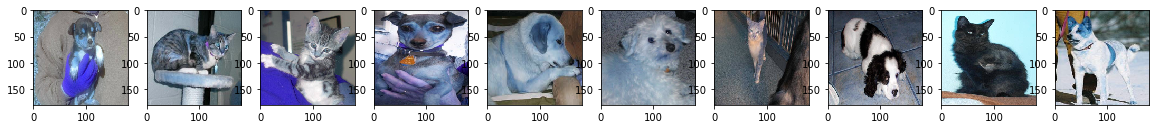

In [0]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 10
for i in range(columns):
    plt.subplot(10 / columns + 1, columns, i + 1)
    plt.imshow(X_test[i])
    

In [0]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (25000, 180, 180, 3)
Shape of labels is: (25000,)


In [0]:

# Split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (20000, 180, 180, 3)
Shape of validation images is: (5000, 180, 180, 3)
Shape of labels is: (20000,)
Shape of labels is: (5000,)


In [0]:
# Length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
ntest = len(X_test)

# Batch size
batch_size = 64

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)   #Scale the image between 0 and 1
                                    # rotation_range=40,
                                    # width_shift_range=0.2,
                                    # height_shift_range=0.2,
                                    # shear_range=0.2,
                                    # zoom_range=0.2,
                                    # horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale


In [0]:
#Create the image generators

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test,batch_size=batch_size,shuffle=False)

In [0]:
# Import the restnet convolution network
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(180,180,3))
# conv_base.summary()














219062272/219055592 [==============================] - 2s 0us/step


In [0]:
# Create the neural network with the various layers
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l2

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu',kernel_regularizer = l2(0.01)))
model.add(Dropout(0.5))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer = l2(0.01)))
model.add(Dropout(0.5))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer = l2(0.01)))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  

model.layers[0].trainable = True
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy','mse'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
import time

start = time.time()

epochs = 30
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='auto')        
       

def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train_generator, epochs = 30,validation_data=val_generator, callbacks=[history, early_stopping])
    
    print("Test Set Prediction")
    predictions = model.predict_generator(test_generator)
    return predictions, history

predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses

running model...


Epoch 1/30
313/313 [==============================] - 228s 728ms/step - loss: 34.1714 - acc: 0.8535 - mean_squared_error: 0.0971 - val_loss: 27.7757 - val_acc: 0.9710 - val_mean_squared_error: 0.0226
Epoch 2/30
313/313 [==============================] - 166s 530ms/step - loss: 21.9716 - acc: 0.9588 - mean_squared_error: 0.0307 - val_loss: 16.7411 - val_acc: 0.9826 - val_mean_squared_error: 0.0140
Epoch 3/30
313/313 [==============================] - 166s 530ms/step - loss: 12.8965 - acc: 0.9727 - mean_squared_error: 0.0205 - val_loss: 9.7416 - val_acc: 0.9848 - val_mean_squared_error: 0.0130
Epoch 4/30
313/313 [==============================] - 166s 531ms/step - loss: 7.4751 - acc: 0.9796 - mean_squared_error: 0.0155 - val_loss: 5.6874 - val_acc: 0.9868 - val_mean_squared_error: 0.0124
Epoch 5/30
313/313 [==============================] - 166s 530ms/step - loss: 4.2883 - acc: 0.9836 - mean_squared_error: 0.0128 - val_loss: 3.2633 - val_acc: 0.9846 - val_mean_squared_

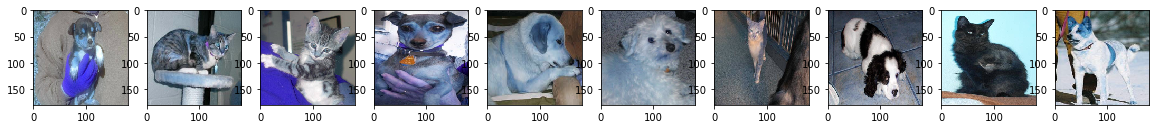

In [0]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 10
for i in range(columns):
    plt.subplot(10 / columns + 1, columns, i + 1)
    plt.imshow(X_test[i])    

In [0]:
new_lst = [int(s) for s in index_lst]
df = pd.DataFrame(predictions)
df.index = new_lst
df.index.name = 'id'
df.rename(columns={0:'label'})
df = df.sort_index(axis=0)

In [0]:
df.to_csv('new_model.csv')
files.download('new_model.csv')